In [1]:
import os
import matplotlib.pyplot as plt
import neurolib.optimize.exploration.explorationUtils as eu
import numpy as np
from neurolib.models.multimodel import MultiModel
from neurolib.models.multimodel.builder import HopfNetwork
from neurolib.optimize.exploration import BoxSearch
from neurolib.utils.functions import getPowerSpectrum
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.utils.stimulus import ZeroInput

import neurolib.utils.pypetUtils as pu
from scipy.signal import find_peaks

from hopf_cfc_network import SlowFastHopfNetwork

import h5py
import pandas as pd

plt.style.use("seaborn")
plt.rcParams['image.cmap'] = 'plasma'

# w instrinsic
# 0.003 ~ 0.5Hz
# 0.005 ~ 0.8Hz
# 0.01 ~ 2Hz
# 0.05 ~ 8Hz
# 0.06 ~ 10Hz
# 0.08 ~ 12Hz
# 0.1 ~ 17Hz
# 0.2 ~ 32Hz
# 0.3 ~ 50Hz

# intrinsic frequencies of SlowFastHopfNetwork are:
# slow intrinsic frequency ~ 6Hz
# fast intrinsic frequency ~ 30Hz

In [2]:
DURATION = 20.0 * 1000  # ms
DT = 0.1  # ms

model = MultiModel(
    SlowFastHopfNetwork(
        number_of_slow_fast_units=1,
        slow_to_fast_connection=0.0,
        fast_to_slow_connection=0.0,
    )
)

model.params["duration"] = 20.0 * 1000
model.params["sampling_dt"] = DT
model.params["dt"] = 0.01  # ms - lower dt for numba backend
# numba backend is the way to go in exploration - much faster
model.params["backend"] = "numba"

# manually add params you want to change during exploration, btw model.params is just a dictionary, so you can add whatever :)
model.params["slow_to_fast"] = 0.0
model.params["fast_to_slow"] = 0.0

In [3]:
parameters = ParameterSpace(
    {
        "slow_to_fast": np.linspace(0.0, 1.0, 21),
        "fast_to_slow": np.linspace(0.0, 1.0, 21)

    }
    ,allow_star_notation=True,
    kind="sequence",)

In [20]:
def modulation_index(P):
    """

    MI = KL(P,U)/log(n), where U is a uniform distribution.
    :param P: mean amplitude for each phase bin, shape (N_BINS,)
    :return modulation index, quantitative measure of phase amplitude coupling
    """
    n_bins = P.shape[0]
    try:
        assert np.isclose(np.sum(P), 1)
    except AssertionError:
        print("Please normalize P!")

    kl = np.log(n_bins) + np.sum(P[P!=0] * np.log(P[P!=0]))
    return kl / np.log(n_bins)


def evaluateSimulation(traj):
    # get model with parameters for this run
    model = search.getModelFromTraj(traj)
    # extract stuff you want
    s_f_conn = model.params["slow_to_fast"]
    f_s_conn = model.params["fast_to_slow"]

    # here you can either manually edit connectivity matrix or init again...
    # example of manual edit - easy for single slow-fast unit with 2x2 conn. matrix
    model.params["*connectivity"] = np.array([[0.0, f_s_conn], [s_f_conn, 0.0]])

    # example of init again - now commented
    #     model = MultiModel(
    #         SlowFastHopfNetwork(
    #             number_of_slow_fast_units=1,
    #             slow_to_fast_connection=s_f_conn,
    #             fast_to_slow_connection=f_s_conn,
    #         )
    #     )

    #     model.params["duration"] = 20.0 * 1000
    #     model.params["sampling_dt"] = DT
    #     model.params["dt"] = 0.01
    #     model.params["backend"] = "numba"
    #     model.params["slow_to_fast"] = 0.0
    #     model.params["fast_to_slow"] = 0.0

    model.run()

    n_bins = 18

    phase_slow = np.arctan2(model.y[0, :], model.x[0, :])
    amp_fast = np.sqrt(model.x[1, :] ** 2 + model.y[1, :] ** 2)
    binned_phase = np.digitize(phase_slow, bins=np.linspace(-np.pi, np.pi, n_bins + 1))
    mean_bin_amp = np.zeros(n_bins + 1)  # in theory index of bins goes from 0 to N_BINS
    for bin_idx in np.unique(binned_phase):
        mean_bin_amp[bin_idx] = np.mean(amp_fast[binned_phase == bin_idx])

    mean_bin_amp = mean_bin_amp[
        1:
    ]  # because in theory there could be stuff that is smaller than -pi, then actually the interval between -pi and the next bin has index 1.
    # normalize the mean amplitude in each bin
    mean_bin_amp = mean_bin_amp / np.sum(mean_bin_amp)
    mi = modulation_index(mean_bin_amp)

    freq_slow, pow_slow = getPowerSpectrum(model.x.T[:, 0], dt=0.1, maxfr=40, spectrum_windowsize=1)
    freq_fast, pow_fast = getPowerSpectrum(model.x.T[:, 1], dt=0.1, maxfr=40, spectrum_windowsize=1)


    peaks_fast, _ = find_peaks(pow_fast,height=max(1e-3, 1.0*np.std(pow_fast)))

    #set the height as ratio of std, we always want peaks that are bigger than 1std
    #one model, with 0.3 fast to slow, choose
    peaks_slow, _ = find_peaks(pow_slow,height=max(1e-3, 0.5*np.std(pow_slow)))


    result_dict = {"modulation_index": mi, "peaks_freq_fast": freq_fast[peaks_fast], "peaks_freq_slow": freq_slow[peaks_slow]}
    search.saveToPypet(result_dict, traj)

In [21]:
search = BoxSearch(
    model=model,
    evalFunction=evaluateSimulation,
    parameterSpace=parameters,
    filename="Hopf_1d_conn_test_wPeaks.hdf",
    ncores=6,
)

MainProcess root INFO     Number of processes: 6
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/Hopf_1d_conn_test_wPeaks.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 42
MainProcess root INFO     BoxSearch: Environment initialized.


In [22]:
search.run()

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-04-28-22H-16M-26S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2022-04-28-22H-16M-26S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2022-04-28-22H-16M-26S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2022-04-28-22H-16M-26S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [23]:
search.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/Hopf_1d_conn_test_wPeaks.hdf
MainProcess root INFO     Analyzing trajectory results-2022-04-28-22H-16M-26S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/Hopf_1d_conn_test_wPeaks.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2022-04-28-22H-16M-26S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 42/42 [00:00<00:00, 215.97it/s]
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 42/42 [00:00<00:00, 2111.02

In [24]:
search.dfResults

,slow_to_fast,fast_to_slow,peaks_freq_slow,peaks_freq_fast,modulation_index
0,0.00,0.00,[6.0],[32.0],6.843023e-10
1,0.05,0.00,[6.0],[32.0],1.067921e-04
2,0.10,0.00,[6.0],[32.0],4.284005e-04
3,0.15,0.00,[6.0],[31.0],9.743407e-04
4,0.20,0.00,[6.0],[31.0],1.758942e-03
5,0.25,0.00,[6.0],[30.0],2.808426e-03
6,0.30,0.00,[6.0],[29.0],4.144104e-03
7,0.35,0.00,[6.0],[28.0],5.821929e-03
8,0.40,0.00,[6.0],[27.0],7.897395e-03
9,0.45,0.00,[6.0],[26.0],1.046196e-02


In [25]:
results_zero_SlowToFast = search.dfResults[search.dfResults["slow_to_fast"]==0]
results_zero_FastToSlow = search.dfResults[search.dfResults["fast_to_slow"]==0]

In [26]:
h5f = h5py.File('modulation_index_no_connections.h5','r')
MI_no_conn = h5f['MI_no_conn'][:]

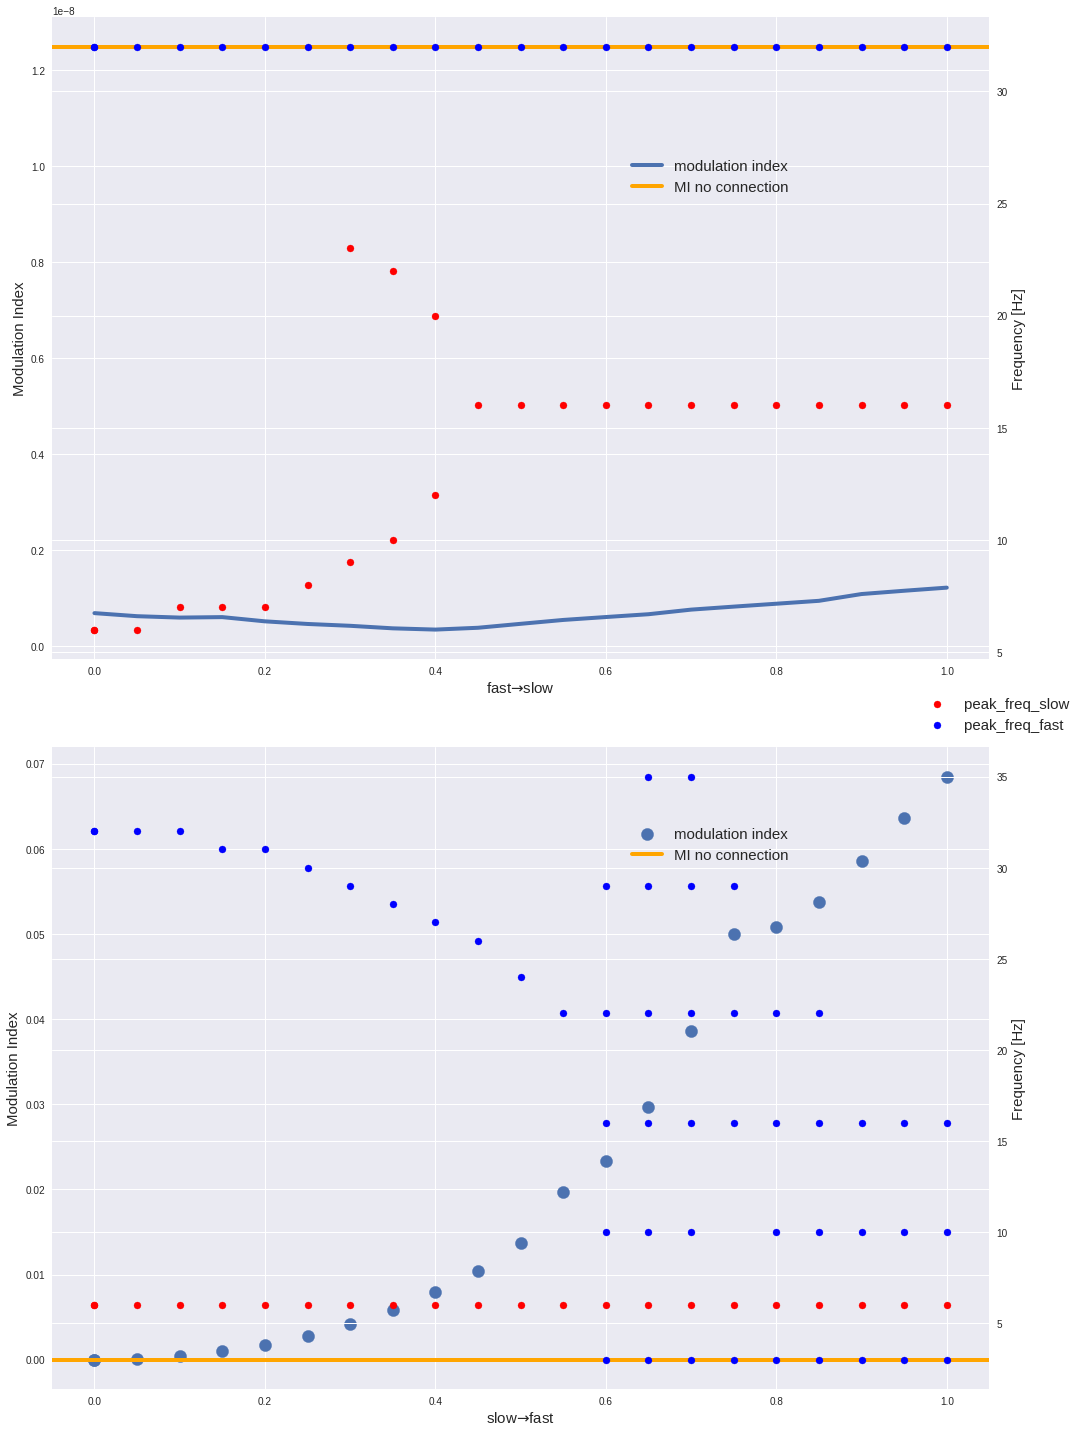

In [27]:
# create all axes we need
fig = plt.figure(figsize=(15,20))
ax0 = plt.subplot(211)
ax1 = ax0.twinx()
ax2 = plt.subplot(212)
ax3 = ax2.twinx()


ax0.plot(results_zero_SlowToFast["fast_to_slow"],results_zero_SlowToFast["modulation_index"], label="modulation index",lw=4)
ax0.set_xlabel( r"fast$\to$slow", fontsize = 15)
ax0.set_ylabel("Modulation Index", fontsize = 15)
ax0.axhline(np.mean(MI_no_conn), c="orange",label="MI no connection",lw=4)
ax0.legend(loc='best', bbox_to_anchor=(0.8,0.8),fontsize = 15)

for x,y in zip(results_zero_SlowToFast["fast_to_slow"],results_zero_SlowToFast["peaks_freq_slow"]):
    ax1.scatter([x]*len(y),y, c='r',label= "peak_freq_slow")


for x,y in zip(results_zero_SlowToFast["fast_to_slow"],results_zero_SlowToFast["peaks_freq_fast"]):
    ax1.scatter([x]*len(y),y, c='b',label="peak_freq_fast")

ax1.set_ylabel("Frequency [Hz]", fontsize = 15)

ax2.scatter(results_zero_FastToSlow["slow_to_fast"],results_zero_FastToSlow["modulation_index"], label="modulation index", s=150)
ax2.set_xlabel( r"slow$\to$fast", fontsize = 15)
ax2.set_ylabel("Modulation Index", fontsize = 15)
ax2.axhline(np.mean(MI_no_conn), c="orange",label="MI no connection",lw=4)
ax2.legend(loc='best', bbox_to_anchor=(0.8,0.8), fontsize = 15)


for x,y in zip(results_zero_FastToSlow["slow_to_fast"],results_zero_FastToSlow["peaks_freq_slow"]):
    ax3.scatter([x]*len(y),y, c='r',label= "peak_freq_slow")


for x,y in zip(results_zero_FastToSlow["slow_to_fast"],results_zero_FastToSlow["peaks_freq_fast"]):
    ax3.scatter([x]*len(y),y, c='b',label="peak_freq_fast")

ax3.set_ylabel("Frequency [Hz]", fontsize = 15)
classes = ['peak_freq_slow', 'peak_freq_fast']
ax3.legend(labels=classes,loc='best', bbox_to_anchor=(1.1,1.1),fontsize = 15)
leg = ax3.get_legend()
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('blue')


plt.tight_layout()
plt.savefig("1d_explor_multiple_peaks_freq.png",dpi=150)
plt.show()

